In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_csv("data.csv", sep='\t')
df.head()

,Link,Tên,Loại nhà,Diện tích,Các loại phòng,Giá,Vị trí,Tiện ích
0,https://www.luxstay.com/vi/rooms/13967,JOLIE HOUSE - BIỆT THỰ HƯỚNG RA VƯỜN - CÁCH TR...,Biệt Thự,100 m2,Nguyên căn · 5 phòng tắm · 6 giường · 4 phòng ...,"2,887,500₫ /đêm","Đà Lạt, Lâm Đồng, Vietnam",NaN
1,https://www.luxstay.com/vi/rooms/33714,Gold&Ruby House- Phòng Quadruple,Căn hộ dịch vụ,20 m2,Phòng riêng · 1 phòng tắm · 2 giường · 1 phòng...,"600,000₫ /đêm","Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Phù hợp với trẻ nhỏ,Không hú..."
2,https://www.luxstay.com/vi/rooms/15456,Maika Condotel - Triple Bedroom,Căn hộ chung cư,110 m2,Nguyên căn · 2 phòng tắm · 3 giường · 3 phòng ...,"2,750,000₫ /đêm","Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Phù hợp với trẻ nhỏ,Tiện ích..."
3,https://www.luxstay.com/vi/rooms/18878,Vườn đom đóm Đà Lạt- Phòng đơn hướng vườn rộng...,Nhà riêng,12 m2,Phòng riêng · 3 phòng tắm · 1 giường · 1 phòng...,"370,000₫ /đêm","Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Không hút thuốc,Tiện ích bếp..."
4,https://www.luxstay.com/vi/rooms/15377,Rebeka's Home 1 - Góc vườn nhỏ tĩnh lặng trước...,Nhà riêng,15 m2,Phòng riêng · 1 phòng tắm · 1 giường · 1 phòng...,"350,000₫ /đêm","Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Phù hợp với trẻ nhỏ,Tiện ích..."


# Chỉnh sửa dữ liệu
Trước tiên ta cần format lại data để tiện làm việc hơn

## Đặt lại tên các cột để thuận tiện trong việc truy cập

In [3]:
df.columns = ["link", "name", "type", "area", "room_types", "price", "location", "other"]
df.head()

,link,name,type,area,room_types,price,location,other
0,https://www.luxstay.com/vi/rooms/13967,JOLIE HOUSE - BIỆT THỰ HƯỚNG RA VƯỜN - CÁCH TR...,Biệt Thự,100 m2,Nguyên căn · 5 phòng tắm · 6 giường · 4 phòng ...,"2,887,500₫ /đêm","Đà Lạt, Lâm Đồng, Vietnam",NaN
1,https://www.luxstay.com/vi/rooms/33714,Gold&Ruby House- Phòng Quadruple,Căn hộ dịch vụ,20 m2,Phòng riêng · 1 phòng tắm · 2 giường · 1 phòng...,"600,000₫ /đêm","Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Phù hợp với trẻ nhỏ,Không hú..."
2,https://www.luxstay.com/vi/rooms/15456,Maika Condotel - Triple Bedroom,Căn hộ chung cư,110 m2,Nguyên căn · 2 phòng tắm · 3 giường · 3 phòng ...,"2,750,000₫ /đêm","Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Phù hợp với trẻ nhỏ,Tiện ích..."
3,https://www.luxstay.com/vi/rooms/18878,Vườn đom đóm Đà Lạt- Phòng đơn hướng vườn rộng...,Nhà riêng,12 m2,Phòng riêng · 3 phòng tắm · 1 giường · 1 phòng...,"370,000₫ /đêm","Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Không hút thuốc,Tiện ích bếp..."
4,https://www.luxstay.com/vi/rooms/15377,Rebeka's Home 1 - Góc vườn nhỏ tĩnh lặng trước...,Nhà riêng,15 m2,Phòng riêng · 1 phòng tắm · 1 giường · 1 phòng...,"350,000₫ /đêm","Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Phù hợp với trẻ nhỏ,Tiện ích..."


## Chỉnh sửa kiểu dữ liệu của các thuộc tính

Trước tiên ta xem xét kiểu dữ liệu của các cột trong dữ liệu:

In [4]:
df.dtypes

link          object
name          object
type          object
area          object
room_types    object
price         object
location      object
other         object
dtype: object

Có thể thấy kiểu dữ liệu của tất cả các cột đều là "object". Tuy nhiên, để có thể áp dụng các thuật toán máy học lên dữ liệu, ta cần đưa dữ liệu của một số thuộc tính về dạng số. Cụ thể, trước tiên ta sẽ format lại kiểu dữ liệu của các thuộc tính "type", "area" và "price"

### Type

"Type" là loại phòng. Ta có thể chuyển đổi thuộc tính này sang dạng sô bằng cách gán một id riêng biệt cho mỗi loại phòng.

Đầu tiên, ta xem số lượng phòng khác nhau:

In [5]:
df["type"].describe()

count                7491
unique                 10
top       Căn hộ chung cư
freq                 2070
Name: type, dtype: object

Như vậy, ta có 10 loại phòng và loại phòng xuất hiện nhiều nhất là "Căn hộ chung cư"

Kế đến, ta đếm số lượng môi loại phòng:

In [6]:
df["type"].value_counts()

Căn hộ chung cư                                                                                                                                                                                                   2070
Căn hộ dịch vụ                                                                                                                                                                                                    1781
Nhà riêng                                                                                                                                                                                                         1614
Căn hộ Studio                                                                                                                                                                                                      955
Khác                                                                                                                                        

Có thể thấy trong 10 loại phòng trên thì chỉ có 6 loại phòng là đúng với thực tế, còn lại là các giá trị lỗi sinh ra trong quá trình thu thập dữ liệu. Ta sẽ tiến hành loại các giá trị lỗi đó trước:

In [7]:
counts = dict(df["type"].value_counts())
real_types = list(df["type"].value_counts().keys())
real_types = [x for x in real_types if counts[x] > 1]
real_types

['Căn hộ chung cư',
 'Căn hộ dịch vụ',
 'Nhà riêng',
 'Căn hộ Studio',
 'Khác',
 'Biệt Thự']

In [8]:
df = df[df["type"].apply(lambda x: x in real_types)]

Kiểm tra lại ta sẽ thấy các giá trị lỗi đã bị loại bỏ:

In [9]:
df["type"].value_counts()

Căn hộ chung cư    2070
Căn hộ dịch vụ     1781
Nhà riêng          1614
Căn hộ Studio       955
Khác                558
Biệt Thự            509
Name: type, dtype: int64

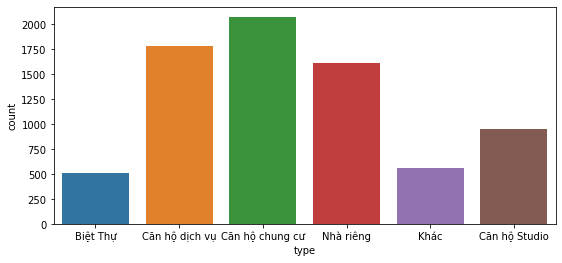

In [10]:
fig = plt.figure(figsize=(9, 4))
sns.countplot(x="type", data=df)
plt.show()

Để thuận lợi cho việc tra cứu lại, ta sẽ tạo một <i>dictionary</i> lưu lại việc mapping các loại phòng thành các id:

In [11]:
type_id = {}
for x in range(len(real_types)):
    type_id[real_types[x]] = x
type_id

{'Căn hộ chung cư': 0,
 'Căn hộ dịch vụ': 1,
 'Nhà riêng': 2,
 'Căn hộ Studio': 3,
 'Khác': 4,
 'Biệt Thự': 5}

Map các loại phòng thành các giá trị số và kiểm tra lại:

In [12]:
df["type"] = df["type"].apply(lambda x: type_id[x])

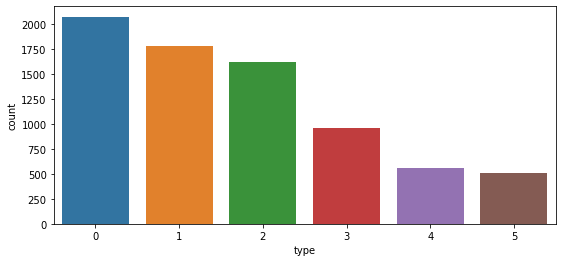

In [13]:
fig = plt.figure(figsize=(9, 4))
sns.countplot(x="type", data=df)
plt.show()

Kiểm tra lại và ta sẽ thấy kiểu dữ liệu của "type" đã được chuyển sang dạng int64

In [14]:
df.dtypes

link          object
name          object
type           int64
area          object
room_types    object
price         object
location      object
other         object
dtype: object

### Area

Dựa vào quan sát, ta thấy chỉ cần loại "m2" trong các giá trị của thuộc tính là đủ

In [15]:
new_area = df["area"].apply(lambda x: float(str(x).split(' ')[0]))
df["area"] = new_area
new_area

0       100.0
1        20.0
2       110.0
3        12.0
4        15.0
        ...  
7502     35.0
7503     25.0
7504     49.0
7505     70.0
7506     25.0
Name: area, Length: 7487, dtype: float64

Sau đó kiểm tra lại kiểu dữ liệu của "area":

In [24]:
df["area"].describe()

count     7366.000000
mean        76.321700
std        230.358698
min          2.000000
25%         25.000000
50%         40.000000
75%         74.000000
max      10000.000000
Name: area, dtype: float64

### Price

Ta sử dụng regular regression để lọc ra giá tiền:

In [21]:
new_price = df["price"].apply(lambda x: re.search("[0-9,]*", str(x)).group().replace(',', ''))
new_price = new_price.apply(lambda x: float(x) if x != "" else float('nan'))
df["price"] = new_price

Sau đó kiểm tra lại kiểu dữ liệu của "price":

In [23]:
df["price"].describe()

count    7.486000e+03
mean     1.268999e+06
std      1.398777e+06
min      7.500000e+04
25%      5.500000e+05
50%      8.500000e+05
75%      1.500000e+06
max      3.024000e+07
Name: price, dtype: float64

## Chọn lựa thuộc tính và tiền xử lý dữ liệu
Ta sẽ tìm hiểu và chọn ra các thuộc tính có ích để áp dụng máy học, đồng thời đưa dữ liệu về dạng giàu thông tin hơn

Trước tiên, ta tạo một hàm để đếm số mẫu dữ liệu bị thiếu đối với một thuộc tính:

In [26]:
def count_missing(df, col):
    print(col, df[col].isnull().sum())

### link
Ta dễ dàng thấy đường dẫn của một phòng cho thuê không hề liên quan đến giá của phòng đó, do đó ta chỉ đơn giản bỏ thuộc tính đó

In [29]:
df = df.drop("link",axis=1)
df.head()

,name,type,area,room_types,price,location,other
0,JOLIE HOUSE - BIỆT THỰ HƯỚNG RA VƯỜN - CÁCH TR...,5,100.0,Nguyên căn · 5 phòng tắm · 6 giường · 4 phòng ...,2887500.0,"Đà Lạt, Lâm Đồng, Vietnam",NaN
1,Gold&Ruby House- Phòng Quadruple,1,20.0,Phòng riêng · 1 phòng tắm · 2 giường · 1 phòng...,600000.0,"Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Phù hợp với trẻ nhỏ,Không hú..."
2,Maika Condotel - Triple Bedroom,0,110.0,Nguyên căn · 2 phòng tắm · 3 giường · 3 phòng ...,2750000.0,"Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Phù hợp với trẻ nhỏ,Tiện ích..."
3,Vườn đom đóm Đà Lạt- Phòng đơn hướng vườn rộng...,2,12.0,Phòng riêng · 3 phòng tắm · 1 giường · 1 phòng...,370000.0,"Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Không hút thuốc,Tiện ích bếp..."
4,Rebeka's Home 1 - Góc vườn nhỏ tĩnh lặng trước...,2,15.0,Phòng riêng · 1 phòng tắm · 1 giường · 1 phòng...,350000.0,"Đà Lạt, Lâm Đồng, Vietnam","Tiện ích gia đình,Phù hợp với trẻ nhỏ,Tiện ích..."


### type
Đầu tiên, ta kiểm tra số mẫu dữ liệu bị thiếu:

In [37]:
count_missing(df, "type")

type 0


Như vậy, thuộc tính "type" không có dữ liệu thiếu. Ta tiếp tục xem xét mối quan hệ giữa loại phòng và giá phòng:

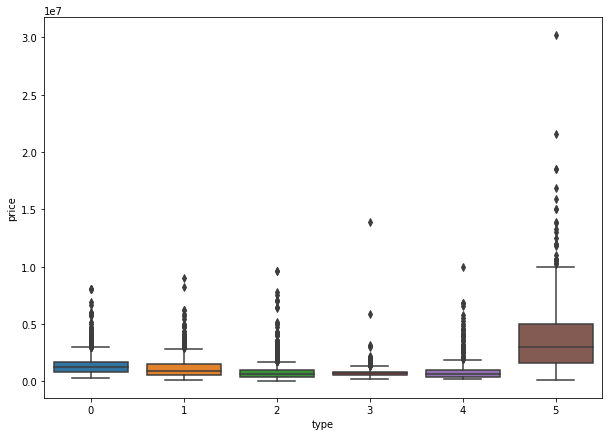

In [36]:
fig = plt.figure(figsize=(10,7))
sns.boxplot(x="type", y="price", data=df)
plt.show()

Ta có thể thấy sự ảnh hưởng của loại nhà lên giá tiền. Cụ thể, ta thấy sự ảnh hưởng trên tăng dần với thứ tự 3, 2, 1, 0 và 5. Đặc biệt, loại nhà có id là 5 cho thấy giá của nó cao hơn hẳn so với các loại nhà khác. Xem lại cách đánh số các loại nhà, ta có thứ tự sau: "Căn hộ studio" -> "Nhà riêng" -> "Căn hộ dịch vụ" -> "Căn hộ chung cư" -> "Biệt thự". Như vậy, ta sẽ đặt giá trị của thuộc tính "type" lại sao cho giá trị ấy thể hiện thứ tự này.

Đối với loại "khác" (4), ta không rõ loại nhà này ảnh hưởng như thế nào đến giá thuê nên ta sẽ đặt một biến riêng để xác định các mẫu với loại phòng này là "không biết".

In [39]:
type_id

{'Căn hộ chung cư': 0,
 'Căn hộ dịch vụ': 1,
 'Nhà riêng': 2,
 'Căn hộ Studio': 3,
 'Khác': 4,
 'Biệt Thự': 5}

In [43]:
id_to_type = {}
for x in type_id:
    id_to_type[type_id[x]] = x
new_type_id = {"Khác":0, "Căn hộ Studio":1, "Nhà riêng":2, "Căn hộ dịch vụ":3, "Căn hộ chung cư":4, "Biệt Thự":5}
df["type"] = df["type"].apply(lambda x: new_type_id[id_to_type[x]])

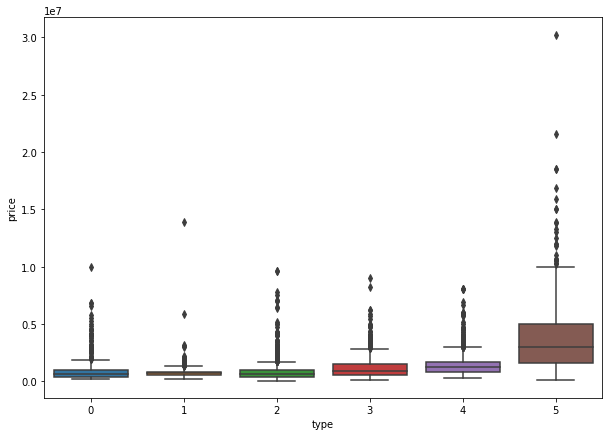

In [45]:
fig = plt.figure(figsize=(10,7))
sns.boxplot(x="type", y="price", data=df)
plt.show()